# Machine Learning - Assignment 3

## Artificial Neural Network

The aim of the assignment is to implement an artificial neural network (mostly) from scratch. This includes implementing or fixing the following:

* Add support for additional activation functions and their derivatives.
* Add support for loss functions and their derivative.
* Add the use of a bias in the forward propagation.
* Add the use of a bias in the backward propagation.

In addition, you will we doing the following as well:

* Test the algorithm on 3 datasets.
* Compare neural networks with and without scaling.
* Hyper-parameter tuning.

The forward and backward propagation is made to work through a single layer, and are re-used multiple times to work for multiple layers.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the implementation.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, you might find yourself going back and and forth to change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
# We set seed to better reproduce results later on.
np.random.seed(12345)

## Neural Network utility functions

### 1) Activation functions

Below is some setup for choosing activation function. Implement 2 additional activation functions, "ReLU" and one more of your choosing.

In [2]:
# Activation functions
def activate(activations, selected_function = "none"):
    if selected_function == "none":
        y = activations
    elif selected_function == "relu":
        y = np.maximum(0, activations)
    elif selected_function == "sigmoid":
        y = 1 / (1 + np.exp(-activations))  # Sigmoid
    return y

In [3]:
# TODO Test your activation functions, is the returning values what you expect?
x = np.array([-2.0, -0.5, 0.0, 1.0, 3.0])
print(activate(x, "relu"))  # output：[0.  0.  0.  1.  3.]

print(activate(x, "sigmoid")) 

[0. 0. 0. 1. 3.]
[0.11920292 0.37754067 0.5        0.73105858 0.95257413]


### 2) Activation function derivatives

Neural networks need both the activation function and its derivative. Finish the code below.

In [4]:
def d_activate(activations, selected_function="none"):
    if selected_function == "none":
        dy = np.ones_like(activations)
    elif selected_function == "relu":
        dy = np.where(activations > 0, 1, 0)
    elif selected_function == "sigmoid":
        dy = activations * (1 - activations)  # Derivative of sigmoid
    return dy

In [5]:
# TODO Test your activation function derivatives, is the returning values what you expect?
activations = np.array([-1, 0, 1, 2])
print(d_activate(activations, "relu"))
print(d_activate(activations, "sigmoid"))

[0 0 1 1]
[-2  0  0 -2]


### 3) Loss functions

To penalize the network when it predicts incorrect, we need to meassure how "bad" the prediction is. This is done with loss-functions.

Similar as with the activation functions, the loss function needs its derivative as well.

Finish the MSE_loss (Mean Squared Error loss), as well as adding one additional loss function.

In [6]:
def MSE_loss(y_hat, y):
    return np.mean((y_hat - y)**2)

def binary_cross_entropy(y_true, y_pred, epsilon=1e-7):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Avoid log(0)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def loss_function(y_pred, y_true, loss_type="mse"):
    if loss_type == "mse":
        return MSE_loss(y_pred, y_true)
    elif loss_type == "bce":
        return binary_cross_entropy(y_true, y_pred)
    else:
        raise ValueError("Invalid loss_type. Use 'mse' or 'bce'.")



The derivatives of the loss is with respect to the predicted value **y_hat**.

In [7]:

def d_loss(y_pred, y_true, loss_type="mse", epsilon=1e-7):
    if loss_type == "mse":
        return 2 * (y_pred - y_true) / y_true.size  # MSE gradient
    elif loss_type == "bce":
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Avoid division by zero errors
        return (y_pred - y_true) / (y_pred * (1 - y_pred)) / y_true.size  # BCE gradient
    else:
        raise ValueError("Invalid loss_type. Use 'mse' or 'bce'.")


In [8]:
y_true = np.array([1, 0, 1, 0])  # True labels for binary classification
y_pred_mse = np.array([0.9, 0.1, 0.8, 0.2])  # Predicted values for MSE
y_pred_bce = np.array([0.95, 0.05, 0.85, 0.15])  # Predicted probabilities for BCE

# Test MSE Loss
mse_loss_value = loss_function(y_pred_mse, y_true, loss_type="mse")
print(f"MSE Loss: {mse_loss_value}")

# Test Binary Cross-Entropy Loss
bce_loss_value = loss_function(y_pred_bce, y_true, loss_type="bce")
print(f"BCE Loss: {bce_loss_value}")

# Test Gradient of MSE Loss
mse_gradient = d_loss(y_pred_mse, y_true, loss_type="mse")
print(f"Gradient of MSE Loss: {mse_gradient}")

# Test Gradient of Binary Cross-Entropy Loss
bce_gradient = d_loss(y_pred_bce, y_true, loss_type="bce")
print(f"Gradient of BCE Loss: {bce_gradient}")

MSE Loss: 0.024999999999999994
BCE Loss: 0.10690611194266275
Gradient of MSE Loss: [-0.05  0.05 -0.1   0.1 ]
Gradient of BCE Loss: [-0.26315789  0.26315789 -0.29411765  0.29411765]


### 4) Forward propagation

The first "fundamental" function for neural networks is to be able to propagate the data forward through the neural network. We will implement this function here.

In [9]:
def propagate_forward(weights, activations, bias, activation_function="none"):
    
    # TODO: Add support for the use of bias

    dot_product = np.dot(activations, weights.T) + bias.T    # 添加这行中的 + bias
    new_activations = activate(dot_product, activation_function) # 应用激活函数

    
    return new_activations

### 5) Back-propagation

To be able to train a neural network, we need to be able to propagate the loss backwards and update the weights. We will implement this function here.

In [10]:
# Calculates the backward gradients that are passed throught the layer in the backward pass.
# Returns both the derivative of the loss in respect to the weights and the input signal (activations).

def propagate_backward(weights, activations, dl_dz, bias, activation_function="none"):
    # NOTE: dl_dz is the derivative of the loss based on the previous layers activations/outputs

    # TODO: Add support for the use of bias
   

    dot_product = np.dot(activations, weights.T) + bias.T
    d_loss = d_activate(dot_product, activation_function) * dl_dz
    d_weights = np.dot(d_loss.T, activations)
    d_bias = np.sum(d_loss, axis=0, keepdims=True).T
    d_activations = np.dot(d_loss, weights)
    return d_weights, d_bias, d_activations


## Neural network implementation

### 6) Fixing the neural network

Below is a class implementation of a MLP neural network. This implementation is still lacking several areas that are needed for the network to be robust and function well. Your task is to improve and fix it with the following:

1. Add a bias to the activation functions, and make sure the bias is also updated during training. 
2. Add a function that trains the network using minibatches (such that the neural network trains on a few samples at a time). 
3. Make use of an validation set in the training function. The model should stop training when the loss starts to increase for the validatin set. This feature should be able to be turned on and off to test the difference.


In [11]:

class NeuralNet:
    def __init__(self, input_dim, output_dim, neurons=[], 
                 activation="relu", output_activation="auto", 
                 loss_type="auto"):
        # 自动配置
        self.output_activation = output_activation
        self.loss_type = loss_type
        if output_activation == "auto":
            self.output_activation = "sigmoid" if output_dim > 1 else "none"
        if loss_type == "auto":
            self.loss_type = "binary_cross_entropy" if output_dim > 1 else "mse"
        
        # 初始化参数
        self.biases = []
        self.weights = []
        self.activations = []
        self.lr = None
        
        prev_dim = input_dim
        for n in neurons:
            self.weights.append(np.random.randn(prev_dim, n) * np.sqrt(2./prev_dim))
            self.biases.append(np.zeros((1, n)))
            self.activations.append(activation)
            prev_dim = n
        
        # 输出层
        self.weights.append(np.random.randn(prev_dim, output_dim) * np.sqrt(2./prev_dim))
        self.biases.append(np.zeros((1, output_dim)))
        self.activations.append(self.output_activation)
        
    def forward(self, x):
        self.cache = []
        a = x
        for w, b, act in zip(self.weights, self.biases, self.activations):
            z = np.dot(a, w) + b
            a = activate(z, act)
            self.cache.append( (z.copy(), a.copy()) )  # 保存中间结果
        return a
    
    def backward(self, x, y, learning_rate):
        # 前向传播获取缓存
        _ = self.forward(x)
        
        # 计算初始梯度
        grad = d_loss(self.cache[-1][1], y, self.loss_type)
        
        # 反向传播
        for i in reversed(range(len(self.weights))):
            z, a = self.cache[i]
            delta = grad * d_activate(z, self.activations[i])
            
            # 计算梯度
            a_prev = x if i == 0 else self.cache[i-1][1]
            dW = np.dot(a_prev.T, delta)
            db = np.sum(delta, axis=0, keepdims=True)
            
            # 更新参数
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
            
            # 传播梯度
            grad = np.dot(delta, self.weights[i].T)
    
    def adjust_weights(self, X_batch, y_batch, learning_rate=None):
        
        if learning_rate is None:
            learning_rate = self.lr or 0.0001  # 默认学习率
        
        self.backward(X_batch, y_batch, learning_rate)
        y_pred = self.forward(X_batch)
        return loss_function(y_pred, y_batch, self.loss_type)
    
    def train_net(self, X, y, batch_size=32, epochs=100, learning_rate=1e-4, use_validation_data=False):
        
        self.lr = learning_rate  # 显式设置学习率
        history = self.train(X, y, 
                           epochs=epochs,
                           batch_size=batch_size,
                           lr=learning_rate)
        return history['loss'], []

    def train(self, X, y, epochs=100, batch_size=32, lr=0.001, val_data=None):
        self.lr = lr  # 保存学习率到实例变量
        history = {'loss': [], 'val_loss': []}  
        for epoch in range(epochs):
            # 随机分批
            indices = np.random.permutation(len(X))
            for i in range(0, len(X), batch_size):
                batch_idx = indices[i:i+batch_size]
                X_batch = X[batch_idx]
                y_batch = y[batch_idx]
                
                # 训练步骤
                self.backward(X_batch, y_batch, lr)
                
            # 记录损失
            y_pred = self.forward(X)
            history['loss'].append(loss_function(y_pred, y, self.loss_type))
            
            if val_data:
                y_val_pred = self.forward(val_data[0])
                history['val_loss'].append(loss_function(y_val_pred, val_data[1], self.loss_type))               
        return history

    
    def evaluate(self, X, y):
        y_pred = self.forward(X)
        if self.loss_type == "cross_entropy":
            return accuracy_score(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))
        else:
            return r2_score(y, y_pred)



## Train Neural Networks

### 7) Simple test

In this a very simple test for you to use and toy around with before using the datasets.

Make sure to test both the **adjust_weights** function and the **train_net** function. What is the difference between the two?

Also, be sure to **plot the loss for each epoch** to see how the network training is progressing!

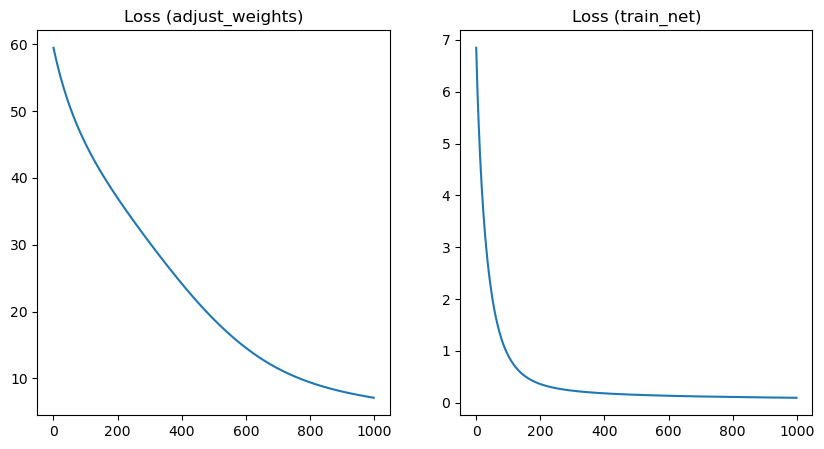

In [12]:
# TODO: You can change most things in this cell if you want to, we encorage it!

n = 1000
d = 4

k = np.random.randint(0,10,(d,1))
x = np.random.normal(0,1,(n,d))
y = np.dot(x,k) + 0.1 + np.random.normal(0,0.01,(n,1))



nn = NeuralNet(d, 1, [18, 12])

loss_1 = [nn.adjust_weights(x, y, learning_rate=1e-4) for _ in range(1000)] 

loss_2, _ = nn.train_net(x, y, batch_size=32, epochs=1000, learning_rate=1e-4)
    

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_1)
plt.title("Loss (adjust_weights)")
    
plt.subplot(1, 2, 2)
plt.plot(loss_2)
plt.title("Loss (train_net)")
plt.show()


### Real test and preprocessing

When using real data and neural networks, it is very important to scale the data between smaller values, usually between 0 and 1. This is because neural networks struggle with larger values as input compared to smaller values. 

To test this, we will use our first dataset and test with and without scaling.

Similar as with assignment 2, we will use the scikit-learn library for this preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

### 8) Dataset 1: Wine - with and without scaling

Wine dataset: https://archive.ics.uci.edu/dataset/109/wine

Train two neural network, one with scaling and one without. Are we able to see any difference in training results or loss over time?

**Note:** Do not train for to many epochs (more than maybe 50-100). The network might "learn" anyway in the end, but you should still be able to see a difference when training.

### Real data and hyper-parameter tuning

Now we are going to use real data, preprocess it, and do hyper-parameter tuning.

Choose two hyper-parameters to tune to try and achive an even better result.

**NOTE:** Changing the number of epochs should be part of the tuning, but it does not count towards the two hyper parameters.


=== Training Scaled Model ===
Epoch   1/200 | Train Loss: 1.3468 Acc: 0.3304 | Val Loss: 1.3931 Acc: 0.3056
Epoch   2/200 | Train Loss: 1.3245 Acc: 0.3504 | Val Loss: 1.3863 Acc: 0.3056
Epoch   3/200 | Train Loss: 1.3325 Acc: 0.3341 | Val Loss: 1.3795 Acc: 0.3056
Epoch   4/200 | Train Loss: 1.3243 Acc: 0.3464 | Val Loss: 1.3728 Acc: 0.3056
Epoch   5/200 | Train Loss: 1.2726 Acc: 0.3545 | Val Loss: 1.3663 Acc: 0.3056
Epoch   6/200 | Train Loss: 1.2838 Acc: 0.3545 | Val Loss: 1.3601 Acc: 0.3056
Epoch   7/200 | Train Loss: 1.2778 Acc: 0.3583 | Val Loss: 1.3535 Acc: 0.3056
Epoch   8/200 | Train Loss: 1.2773 Acc: 0.3579 | Val Loss: 1.3471 Acc: 0.3056
Epoch   9/200 | Train Loss: 1.2718 Acc: 0.3661 | Val Loss: 1.3407 Acc: 0.3056
Epoch  10/200 | Train Loss: 1.2497 Acc: 0.3702 | Val Loss: 1.3345 Acc: 0.3056
Epoch  11/200 | Train Loss: 1.2653 Acc: 0.3661 | Val Loss: 1.3283 Acc: 0.3056
Epoch  12/200 | Train Loss: 1.2488 Acc: 0.3743 | Val Loss: 1.3221 Acc: 0.3056
Epoch  13/200 | Train Loss: 1.237

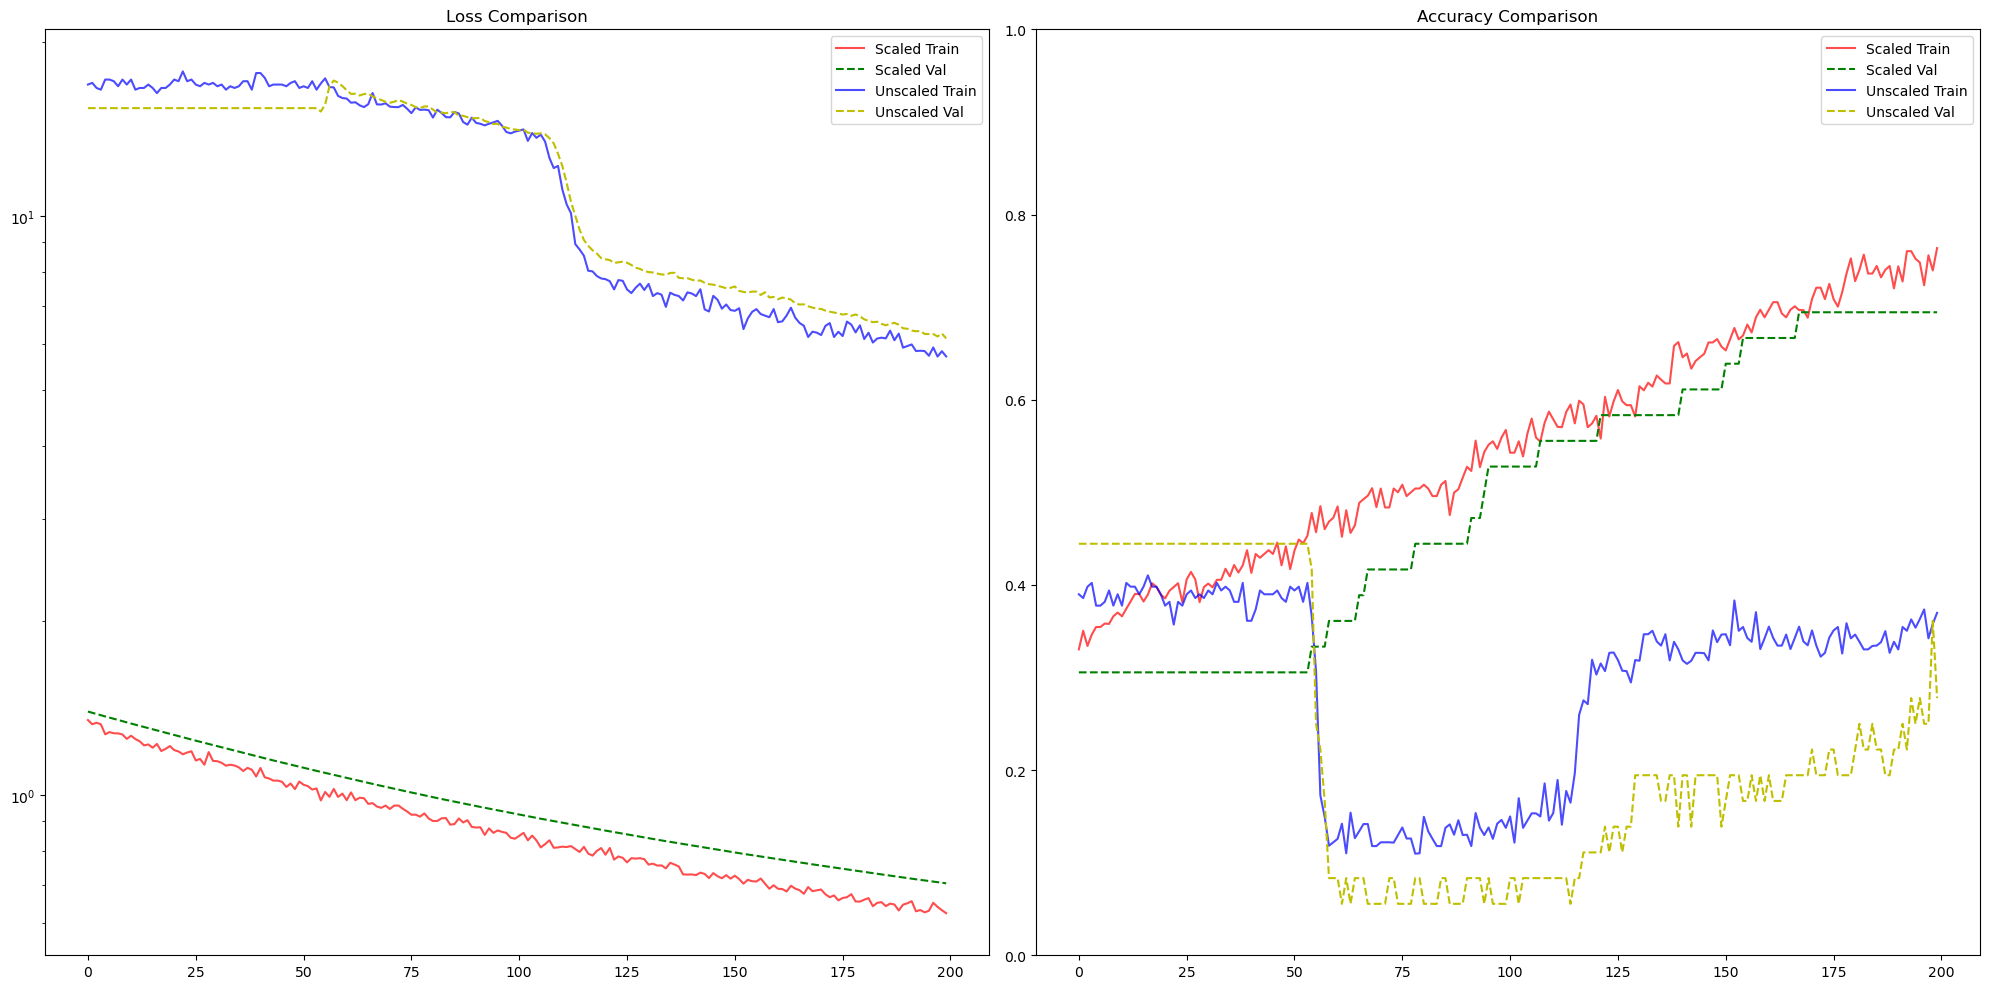

In [35]:

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def cross_entropy_loss(y_pred, y_true_labels):
    batch_size = y_pred.shape[0]
    num_classes = y_pred.shape[1]
    y_true_onehot = np.zeros((batch_size, num_classes))
    y_true_onehot[np.arange(batch_size), y_true_labels.flatten().astype(int)] = 1
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.sum(y_true_onehot * np.log(y_pred)) / batch_size


class NeuralNet_wine:
    def __init__(self, input_dim, output_dim, neurons=[64, 32]):
        self.weights = []
        self.biases = []
        self.activation_funcs = []
        
        # initial
        prev_dim = input_dim
        for n in neurons:
            self.weights.append(np.random.randn(prev_dim, n) * np.sqrt(2./prev_dim))
            self.biases.append(np.zeros((1, n)))
            self.activation_funcs.append("leaky_relu")
            prev_dim = n
        
        # output Layer
        self.weights.append(np.random.randn(prev_dim, output_dim) * np.sqrt(2./prev_dim))
        self.biases.append(np.zeros((1, output_dim)))
        self.activation_funcs.append("softmax")
        
    def forward_wine(self, x):
        self.cache = []
        a_prev = x
        for w, b, af in zip(self.weights, self.biases, self.activation_funcs):
            z = np.dot(a_prev, w) + b
            if af == "leaky_relu":
                a = leaky_relu(z)
            elif af == "softmax":
                
                a = softmax(z)
            # 保存：输入激活值、线性输出、激活输出
            self.cache.append( (a_prev.copy(), z.copy(), a.copy()) )
            a_prev = a
        return a_prev
    
    def backward_wine(self, y_true_onehot, learning_rate):
        m = y_true_onehot.shape[0]
        gradients = []
        
        # output
        a_prev, z, a = self.cache[-1]
        delta = (a - y_true_onehot) / m
        gradients.append(delta)
        
        # 隐藏层反向传播
        for i in reversed(range(len(self.weights)-1)):
            w_next = self.weights[i+1]
            a_prev, z, a = self.cache[i]
            delta = np.dot(delta, w_next.T) * (z > 0).astype(float)
            gradients.append(delta)

        gradients = gradients[::-1]
        

        for i in range(len(self.weights)):
            a_prev, z, a = self.cache[i]
            dW = np.dot(a_prev.T, gradients[i])
            db = np.sum(gradients[i], axis=0, keepdims=True)
            
            
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
    
    def train_wine(self, X_train, y_train, X_val, y_val, 
             epochs=200, batch_size=64, learning_rate=1e-5, patience=10):
        y_train_onehot = np.zeros((len(y_train), self.weights[-1].shape[1]))
        y_train_onehot[np.arange(len(y_train)), y_train] = 1
        
        history = {'train_loss': [], 'train_acc': [], 
                  'val_loss': [], 'val_acc': []}
        best_val_loss = float('inf')
        no_improve = 0
        
        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train))
            epoch_loss = []
            epoch_acc = []
            
            for i in range(0, len(X_train), batch_size):
                batch_idx = indices[i:i+batch_size]
                X_batch = X_train[batch_idx]
                y_batch_labels = y_train[batch_idx]
                y_batch_onehot = y_train_onehot[batch_idx]
                
                # 前向传播
                output = self.forward_wine(X_batch)
                loss = cross_entropy_loss(output, y_batch_labels)
                acc = np.mean(np.argmax(output, axis=1) == y_batch_labels)
                
                # 反向传播
                self.backward_wine(y_batch_onehot, learning_rate)
                
                epoch_loss.append(loss)
                epoch_acc.append(acc)
            
            # 验证评估
            val_output = self.forward_wine(X_val)
            val_loss = cross_entropy_loss(val_output, y_val)
            val_acc = np.mean(np.argmax(val_output, axis=1) == y_val)
            
            # 记录历史
            history['train_loss'].append(np.mean(epoch_loss))
            history['train_acc'].append(np.mean(epoch_acc))
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
        
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                 f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f} | "
                 f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        return history

# ------------------- 数据预处理 -------------------
def data_wine():
    wine = pd.read_csv('wine.csv').drop(0)
    X = wine.drop("class", axis=1).values.astype(float)
    y = wine["class"].values.astype(int)
    y = np.vectorize({1:0, 2:1, 3:2}.get)(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# ------------------- 主程序 -------------------
def main_wine():
    X_train, X_val, X_test, y_train, y_val, y_test = data_wine()
    
    # 标准化数据
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # 训练标准化模型
    print("\n=== Training Scaled Model ===")
    nn_scaled = NeuralNet_wine(input_dim=X_train_scaled.shape[1], output_dim=3)
    history_scaled = nn_scaled.train_wine(
        X_train_scaled, y_train, X_val_scaled, y_val,
        learning_rate=5e-4, epochs=200, patience=10
    )
    
    # 训练未标准化模型
    print("\n=== Training Unscaled Model ===")
    nn_raw = NeuralNet_wine(input_dim=X_train.shape[1], output_dim=3)
    history_raw = nn_raw.train_wine(
        X_train, y_train, X_val, y_val,
        learning_rate=1e-6, epochs=200, patience=10
    )
    
    # 可视化
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.plot(history_scaled['train_loss'], label='Scaled Train', c='r', alpha=0.7)
    plt.plot(history_scaled['val_loss'], '--', c='g', label='Scaled Val')
    plt.plot(history_raw['train_loss'], label='Unscaled Train', c='b', alpha=0.7)
    plt.plot(history_raw['val_loss'], '--', c='y', label='Unscaled Val')
    plt.yscale('log')
    plt.title("Loss Comparison")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history_scaled['train_acc'], label='Scaled Train', c='r', alpha=0.7)
    plt.plot(history_scaled['val_acc'], '--', c='g', label='Scaled Val')
    plt.plot(history_raw['train_acc'], label='Unscaled Train', c='b', alpha=0.7)
    plt.plot(history_raw['val_acc'], '--', c='y', label='Unscaled Val')
    plt.ylim(0.0, 1.0)
    plt.title("Accuracy Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

main_wine()

### 9) Dataset 2: Mushroom

Mushroom dataset: https://archive.ics.uci.edu/dataset/73/mushroom

Note: This dataset has one feature with missing values. Remove this feature.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler



def relu(z):
    return np.maximum(0, z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# ------------------- 神经网络类 -------------------
class NeuralNet_BC:
    def __init__(self, input_dim, neurons=[64, 32]):
        self.weights = []
        self.biases = []
        
        # 初始化参数
        prev_dim = input_dim
        for n in neurons:
            self.weights.append(np.random.randn(prev_dim, n) * np.sqrt(2./prev_dim))
            self.biases.append(np.zeros((1, n)))
            prev_dim = n
        
        # 输出层
        self.weights.append(np.random.randn(prev_dim, 1) * np.sqrt(2./prev_dim))
        self.biases.append(np.zeros((1, 1)))
        
    def forward(self, x):
        self.cache = []
        a_prev = x
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(a_prev, w) + b
            if i < len(self.weights)-1:
                a = relu(z)
            else:
                a = sigmoid(z)
            self.cache.append( (a_prev.copy(), z.copy()) )
            a_prev = a
        return a_prev
    
    def backward(self, y_true, learning_rate):
        m = y_true.shape[0]
        gradients = []
        
        # 输出层梯度
        a_prev, z = self.cache[-1]
        a = sigmoid(z)
        delta = (a - y_true.reshape(-1,1)) / m
        gradients.append(delta)
        
        # 隐藏层反向传播
        for i in reversed(range(len(self.weights)-1)):
            w_next = self.weights[i+1]
            a_prev, z = self.cache[i]
            delta = np.dot(delta, w_next.T) * (z > 0).astype(float)
            gradients.append(delta)
        
        gradients = gradients[::-1]
        
        # 更新参数
        for i in range(len(self.weights)):
            a_prev, _ = self.cache[i]
            dW = np.dot(a_prev.T, gradients[i])
            db = np.sum(gradients[i], axis=0, keepdims=True)
            
            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * db
    
    def train_BC(self, X_train, y_train, X_val, y_val, 
             epochs=50, batch_size=64, learning_rate=1e-7):
        history = {'train_loss': [], 'train_acc': [], 
                  'val_loss': [], 'val_acc': []}
        
        for epoch in range(epochs):
            indices = np.random.permutation(len(X_train))
            epoch_loss = []
            epoch_acc = []
            
            for i in range(0, len(X_train), batch_size):
                batch_idx = indices[i:i+batch_size]
                X_batch = X_train[batch_idx]
                y_batch = y_train[batch_idx]
                
                # 前向传播
                output = self.forward(X_batch)
                loss = binary_cross_entropy_loss(output, y_batch)
                acc = np.mean((output >= 0.5).astype(int) == y_batch)
                
                # 反向传播
                self.backward(y_batch, learning_rate)
                
                epoch_loss.append(loss)
                epoch_acc.append(acc)
            
            # 验证评估
            val_output = self.forward(X_val)
            val_loss = binary_cross_entropy_loss(val_output, y_val)
            val_acc = np.mean((val_output >= 0.5).astype(int) == y_val)
            
            history['train_loss'].append(np.mean(epoch_loss))
            history['train_acc'].append(np.mean(epoch_acc))
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                 f"Train Loss: {history['train_loss'][-1]:.4f} Acc: {history['train_acc'][-1]:.4f} | "
                 f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        return history


=== Training Mushroom Model ===
Epoch   1/50 | Train Loss: 0.9127 Acc: 0.4965 | Val Loss: 0.9256 Acc: 0.4954
Epoch   2/50 | Train Loss: 0.9106 Acc: 0.4969 | Val Loss: 0.9251 Acc: 0.4954
Epoch   3/50 | Train Loss: 0.9122 Acc: 0.4973 | Val Loss: 0.9246 Acc: 0.4955
Epoch   4/50 | Train Loss: 0.9097 Acc: 0.4970 | Val Loss: 0.9242 Acc: 0.4955
Epoch   5/50 | Train Loss: 0.9153 Acc: 0.4969 | Val Loss: 0.9237 Acc: 0.4955
Epoch   6/50 | Train Loss: 0.9060 Acc: 0.4984 | Val Loss: 0.9233 Acc: 0.4956
Epoch   7/50 | Train Loss: 0.9105 Acc: 0.4978 | Val Loss: 0.9229 Acc: 0.4956
Epoch   8/50 | Train Loss: 0.9069 Acc: 0.4986 | Val Loss: 0.9225 Acc: 0.4956
Epoch   9/50 | Train Loss: 0.9065 Acc: 0.4975 | Val Loss: 0.9220 Acc: 0.4956
Epoch  10/50 | Train Loss: 0.9074 Acc: 0.4980 | Val Loss: 0.9217 Acc: 0.4956
Epoch  11/50 | Train Loss: 0.9041 Acc: 0.5016 | Val Loss: 0.9213 Acc: 0.4957
Epoch  12/50 | Train Loss: 0.9062 Acc: 0.4982 | Val Loss: 0.9209 Acc: 0.4957
Epoch  13/50 | Train Loss: 0.9060 Acc: 0.49

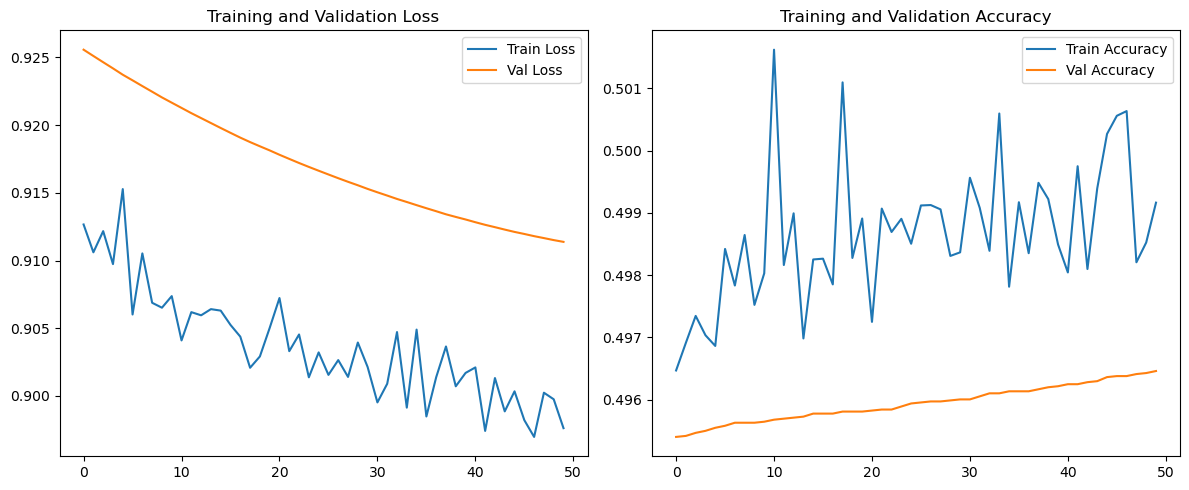

In [33]:
def data_mushroom():
    df = pd.read_csv("mushroom.csv")
    
    y = df.iloc[:, 0].map({'p':1, 'e':0}).values
    X = df.iloc[:, 1:]
    
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    X_encoded = encoder.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# ------------------- 主程序 -------------------
def main_mushroom():
    X_train, X_val, X_test, y_train, y_val, y_test = data_mushroom()
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    input_dim = X_train.shape[1]
    nn = NeuralNet_BC(input_dim=input_dim, neurons=[64, 32])
    
    print("\n=== Training Mushroom Model ===")
    history = nn.train_BC(X_train, y_train, X_val, y_val, epochs=50, batch_size=64, learning_rate=1e-5)
    
    test_output = nn.forward(X_test)
    test_acc = np.mean((test_output >= 0.5).astype(int) == y_test.reshape(-1,1))
    print(f"\nTest Accuracy: {test_acc:.4f}")


    # 可视化结果
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

main_mushroom()


When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: learning rate
* Parameter 2: batch size

* Neural network sizes:  [[18, 12], [10, 15]]


=== Training Mushroom Model ===
Epoch   1/50 | Train Loss: 1.0240 Acc: 0.5142 | Val Loss: 1.0686 Acc: 0.5099
Epoch   2/50 | Train Loss: 1.0175 Acc: 0.5117 | Val Loss: 1.0660 Acc: 0.5099
Epoch   3/50 | Train Loss: 1.0188 Acc: 0.5131 | Val Loss: 1.0634 Acc: 0.5099
Epoch   4/50 | Train Loss: 1.0162 Acc: 0.5116 | Val Loss: 1.0609 Acc: 0.5099
Epoch   5/50 | Train Loss: 1.0113 Acc: 0.5138 | Val Loss: 1.0584 Acc: 0.5099
Epoch   6/50 | Train Loss: 1.0081 Acc: 0.5145 | Val Loss: 1.0559 Acc: 0.5098
Epoch   7/50 | Train Loss: 1.0076 Acc: 0.5138 | Val Loss: 1.0535 Acc: 0.5098
Epoch   8/50 | Train Loss: 1.0061 Acc: 0.5126 | Val Loss: 1.0511 Acc: 0.5098
Epoch   9/50 | Train Loss: 1.0018 Acc: 0.5124 | Val Loss: 1.0487 Acc: 0.5097
Epoch  10/50 | Train Loss: 1.0011 Acc: 0.5132 | Val Loss: 1.0464 Acc: 0.5097
Epoch  11/50 | Train Loss: 0.9997 Acc: 0.5128 | Val Loss: 1.0441 Acc: 0.5097
Epoch  12/50 | Train Loss: 0.9979 Acc: 0.5120 | Val Loss: 1.0418 Acc: 0.5096
Epoch  13/50 | Train Loss: 0.9947 Acc: 0.51

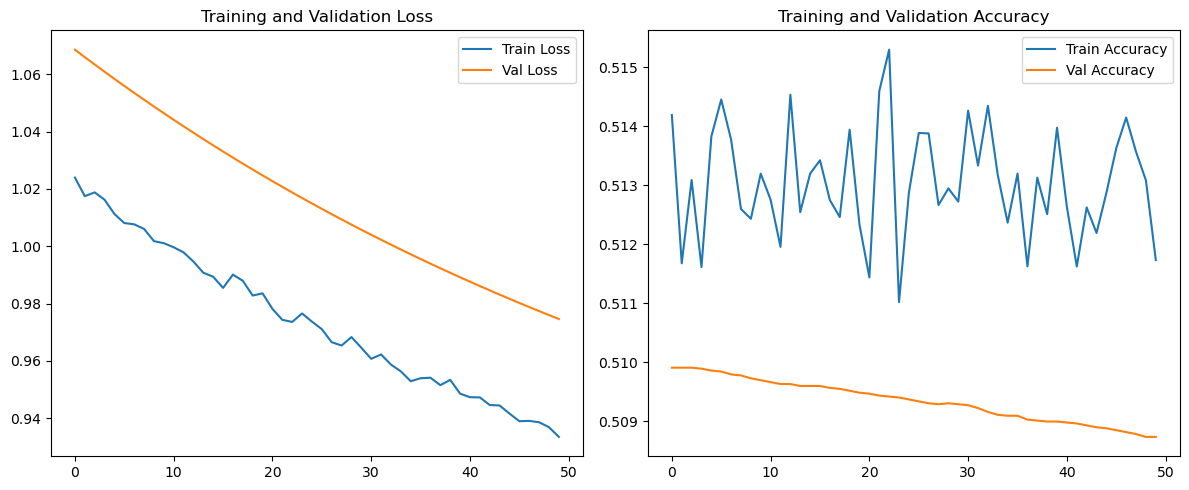

In [34]:
def main_mushroom_hypertuned():

    X_train, X_val, X_test, y_train, y_val, y_test = data_mushroom()
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    input_dim = X_train.shape[1]
    nn = NeuralNet_BC(input_dim=input_dim, neurons=[32, 15])
    
    print("\n=== Training Mushroom Model ===")
    history = nn.train_BC(X_train, y_train, X_val, y_val, epochs=50, batch_size=30, learning_rate=0.00001)
    
    test_output = nn.forward(X_test)
    test_acc = np.mean((test_output >= 0.5).astype(int) == y_test.reshape(-1,1))
    print(f"\nTest Accuracy: {test_acc:.4f}")


    # 可视化结果
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

main_mushroom_hypertuned()

### 10) Dataset 3: Adult

Adult dataset: https://archive.ics.uci.edu/dataset/2/adult

**IMPORTANT NOTE:** This dataset is much larger than the previous two (48843 instances). If your code runs slow on your own computer, you may exclude parts of this dataset, but you must keep a minimum of 10000 datapoints.


=== Initial Training ===
Epoch   1/50 | Train Loss: 0.6677 Acc: 0.7466 | Val Loss: 0.6610 Acc: 0.7545
Epoch   2/50 | Train Loss: 0.6692 Acc: 0.7466 | Val Loss: 0.6606 Acc: 0.7545
Epoch   3/50 | Train Loss: 0.6672 Acc: 0.7467 | Val Loss: 0.6602 Acc: 0.7545
Epoch   4/50 | Train Loss: 0.6674 Acc: 0.7464 | Val Loss: 0.6598 Acc: 0.7540
Epoch   5/50 | Train Loss: 0.6676 Acc: 0.7460 | Val Loss: 0.6594 Acc: 0.7540
Epoch   6/50 | Train Loss: 0.6642 Acc: 0.7466 | Val Loss: 0.6590 Acc: 0.7540
Epoch   7/50 | Train Loss: 0.6658 Acc: 0.7465 | Val Loss: 0.6586 Acc: 0.7540
Epoch   8/50 | Train Loss: 0.6654 Acc: 0.7463 | Val Loss: 0.6583 Acc: 0.7540
Epoch   9/50 | Train Loss: 0.6642 Acc: 0.7459 | Val Loss: 0.6579 Acc: 0.7540
Epoch  10/50 | Train Loss: 0.6647 Acc: 0.7460 | Val Loss: 0.6575 Acc: 0.7538
Epoch  11/50 | Train Loss: 0.6643 Acc: 0.7461 | Val Loss: 0.6572 Acc: 0.7538
Epoch  12/50 | Train Loss: 0.6627 Acc: 0.7465 | Val Loss: 0.6568 Acc: 0.7535
Epoch  13/50 | Train Loss: 0.6619 Acc: 0.7458 | Va

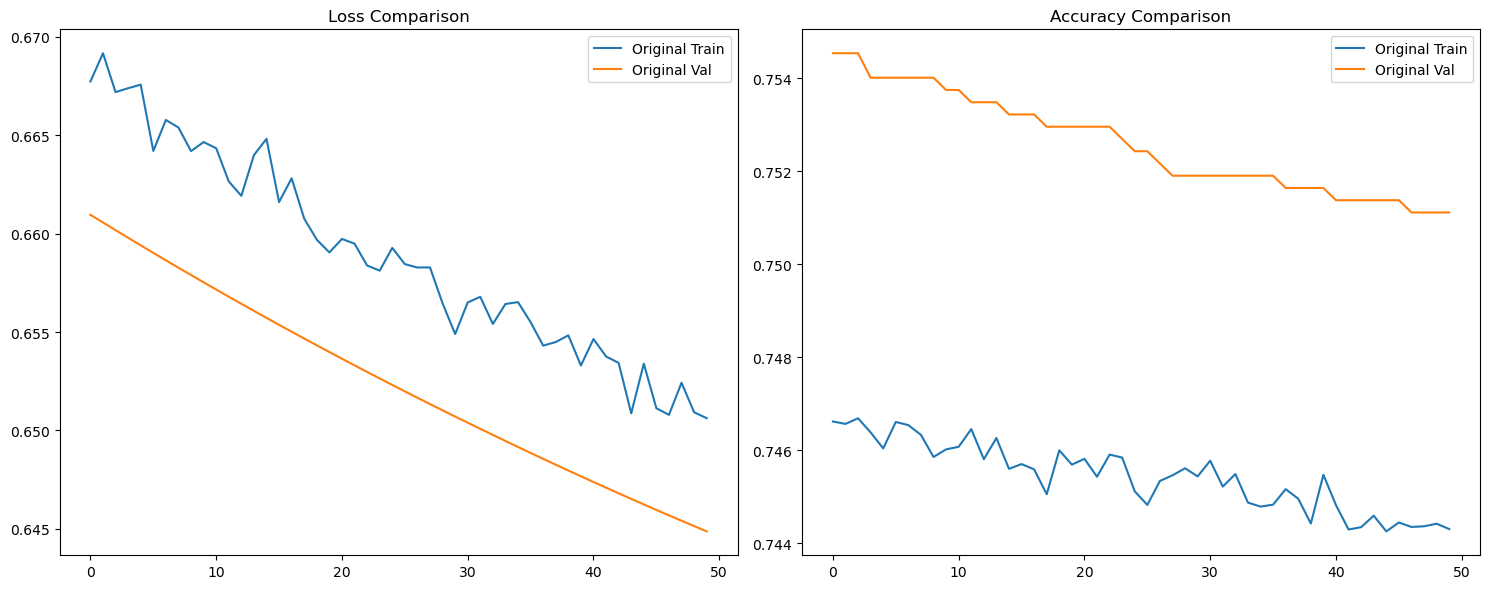

In [17]:

def preprocess_adult(data):
    
    data = data.replace('?', np.nan).dropna()
    
    
    categorical_cols = [
        'workclass', 
        'education',       
        'marital-status', 
        'occupation',
        'relationship',
        'race',
        'gender',         
        'native-country'
    ]
    
    numeric_cols = [
        'age',
        'fnlwgt',
        'educational-num', 
        'capital-gain',    
        'capital-loss',    
        'hours-per-week'
    ]
    
    # 处理分类变量
    le = LabelEncoder()
    for col in categorical_cols:
        data[col] = le.fit_transform(data[col])
    
    # 明确选择所有需要的特征
    processed_data = data[categorical_cols + numeric_cols]
    processed_data['income'] = data['income'].map({'<=50K':0, '>50K':1})
    
    return processed_data

def data_adult(sample_size=10000):
    adult = pd.read_csv('adult.csv')
    adult = preprocess_adult(adult)
    
    # 采样保持数据量
    if len(adult) > sample_size:
        adult = adult.sample(n=sample_size, random_state=42)
    
    X = adult.drop("income", axis=1).values.astype(float)
    y = adult["income"].values.astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, random_state=42)
    
    # 标准化
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    return X_train, X_val, X_test, y_train, y_val, y_test


def main_adult():
    X_train, X_val, X_test, y_train, y_val, y_test = data_adult()
    

    print("\n=== Initial Training ===")
    nn = NeuralNet_BC(input_dim=X_train.shape[1], neurons=[64, 32])
    history = nn.train_BC(X_train, y_train, X_val, y_val,
                      epochs=50, learning_rate=1e-5)
    

    plt.figure(figsize=(15,6))
    
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Original Train')
    plt.plot(history['val_loss'], label='Original Val')
    plt.title('Loss Comparison')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Original Train')
    plt.plot(history['val_acc'], label='Original Val')
    plt.title('Accuracy Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


main_adult()

When hyper-parameter tuning, please write the parameters and network sizes you test here:

* Parameter 1: learning rate
* Parameter 2:batch size

* Neural network sizes:  [[18, 12], [10, 15]]


=== After Hyperparameter Tuning ===
Epoch   1/50 | Train Loss: 0.6872 Acc: 0.6345 | Val Loss: 0.6822 Acc: 0.6423
Epoch   2/50 | Train Loss: 0.6840 Acc: 0.6378 | Val Loss: 0.6787 Acc: 0.6457
Epoch   3/50 | Train Loss: 0.6814 Acc: 0.6397 | Val Loss: 0.6753 Acc: 0.6481
Epoch   4/50 | Train Loss: 0.6771 Acc: 0.6432 | Val Loss: 0.6720 Acc: 0.6502
Epoch   5/50 | Train Loss: 0.6746 Acc: 0.6473 | Val Loss: 0.6690 Acc: 0.6526
Epoch   6/50 | Train Loss: 0.6714 Acc: 0.6499 | Val Loss: 0.6660 Acc: 0.6557
Epoch   7/50 | Train Loss: 0.6688 Acc: 0.6533 | Val Loss: 0.6632 Acc: 0.6570
Epoch   8/50 | Train Loss: 0.6667 Acc: 0.6550 | Val Loss: 0.6606 Acc: 0.6586
Epoch   9/50 | Train Loss: 0.6639 Acc: 0.6567 | Val Loss: 0.6580 Acc: 0.6599
Epoch  10/50 | Train Loss: 0.6619 Acc: 0.6598 | Val Loss: 0.6556 Acc: 0.6621
Epoch  11/50 | Train Loss: 0.6586 Acc: 0.6621 | Val Loss: 0.6533 Acc: 0.6634
Epoch  12/50 | Train Loss: 0.6572 Acc: 0.6634 | Val Loss: 0.6511 Acc: 0.6657
Epoch  13/50 | Train Loss: 0.6561 Acc: 

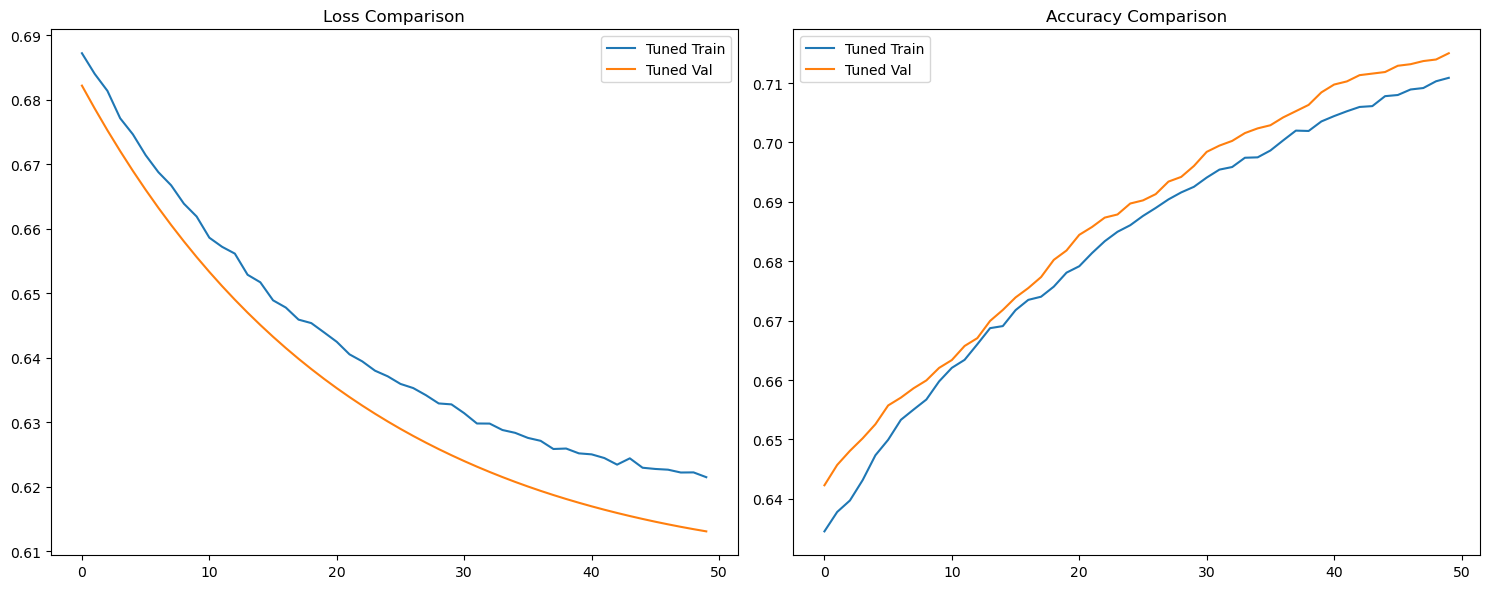

In [18]:
def main_adult_hypertuned():
    X_train, X_val, X_test, y_train, y_val, y_test = data_adult()
    
    # 超参数调优后
    print("\n=== After Hyperparameter Tuning ===")
    nn_tuned = NeuralNet_BC(input_dim=X_train.shape[1], neurons=[128, 64])
    history_tuned = nn_tuned.train_BC(X_train, y_train, X_val, y_val,
                                  epochs=50, learning_rate=5e-5,
                                  batch_size=128)
    
    # # 测试评估
    # test_output = nn_tuned.forward(X_test)
    # test_acc = np.mean((test_output >= 0.5).astype(int) == y_test)
    # print(f"\nFinal Test Accuracy: {test_acc:.4f}")
    
    # 可视化
    plt.figure(figsize=(15,6))
    
    plt.subplot(1,2,1)
    plt.plot(history_tuned['train_loss'], label='Tuned Train')
    plt.plot(history_tuned['val_loss'], label='Tuned Val')
    plt.title('Loss Comparison')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history_tuned['train_acc'], label='Tuned Train')
    plt.plot(history_tuned['val_acc'], label='Tuned Val')
    plt.title('Accuracy Comparison')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


main_adult_hypertuned()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why would we want to use different activation functions?

2) Why would we want to use different loss functions?

3) Why are neural networks sensitive to large input values?

4) What is the role of the bias? 

5) What is the purpose of hyper-parameter tuning?

6) A small example neural network will be shown during the oral examination. You will be asked a few basic questions related to the number of weights, biases, inputs and outputs.

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!